In [180]:
import sys
import csv
import bz2

import numpy as np
import cv2
import pickle
from PIL import Image

from colormath.color_diff_matrix import delta_e_cie2000
from colormath.color_objects import LabColor

from skimage import img_as_float, img_as_ubyte
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.filters import sobel
from skimage.segmentation import mark_boundaries
from PIL import Image 
def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)
def lab_cie2cv(cie_lab):
    cv_lab = np.zeros_like(cie_lab)
    cv_lab[...,0] = cie_lab[...,0] * 255 / 100
    cv_lab[...,1] = cie_lab[...,1] + 128
    cv_lab[...,2] = cie_lab[...,2] + 128
    return cv_lab.astype(np.uint8)
def lab_cv2cie(cv_lab):
    cv_lab = cv_lab.astype(float)
    cie_lab = np.zeros_like(cv_lab)
    cie_lab[...,0] = cv_lab[...,0] * 100 / 255
    cie_lab[...,1] = cv_lab[...,1] - 128
    cie_lab[...,2] = cv_lab[...,2] - 128
    return cie_lab
def create_bgr(color):
    img = np.zeros((50,50,3))
    img[...,0] = color[0]
    img[...,1] = color[1]
    img[...,2] = color[2]
    return img.astype(np.uint8)


In [2]:
infile = open('/media/allen/mass/lab-matrix.pk','rb')
lab_matrix = pickle.load(infile, encoding='latin1')
infile.close()

infile = open('/media/allen/mass/lab-colors.pk','rb')
lab_colors = pickle.load(infile, encoding='latin1')
infile.close()

In [33]:
len(lab_colors)

197525

In [3]:
lab_colors = np.array(lab_colors)

In [70]:
mask = lab_colors == 'white'
a = lab_matrix[mask]

In [71]:
a.shape

(18, 3)

In [6]:
a.reshape(-1, 7*79, 3)

array([[[18.84307605, 40.30386567, 28.96416096],
        [18.85246356, 40.32955458, 28.56771335],
        [18.93672456, 40.5596757 , 24.99929415],
        ...,
        [22.14316283, 44.36763473, 25.38848852],
        [22.15511802, 44.40015033, 24.77932023],
        [22.00216346, 43.98300818, 32.54327038]],

       [[22.16758295, 44.43403639, 24.14560696],
        [22.18056284, 44.46930509, 23.50320645],
        [22.19406271, 44.50596806, 22.85607602],
        ...,
        [25.78791982, 41.66014006, 37.80188072],
        [25.89931353, 41.34691672, 37.90457631],
        [26.01449706, 41.02370706, 38.01026476]],

       [[26.13345471, 40.69062137, 38.11888003],
        [26.25616805, 40.3477793 , 38.23035192],
        [26.38261593, 39.99530947, 38.34460626],
        ...,
        [28.19669852, 42.33630347, 40.57375598],
        [28.32058006, 41.99074248, 40.67616165],
        [28.4479342 , 41.63627612, 40.78078817]],

       ...,

       [[51.40592899, 74.50508781, 64.89651779],
        [51

In [184]:
dist = delta_e_cie2000(np.array([0,0,0]), lab_matrix)
similar_lab = np.sort(dist)
indice = dist.argsort()
print(lab_colors[indice][similar_lab<15])
print(lab_matrix[indice][similar_lab<15])

['black' 'black' 'black' ... 'blue' 'blue' 'brown']
[[  0.           0.           0.        ]
 [  0.05830464   0.26148098   0.09213212]
 [  0.21586875  -0.26148424  -0.09219283]
 ...
 [  3.88471858   5.75698055 -20.553542  ]
 [ 14.03836037  -5.77885965 -14.69831127]
 [ 11.72996098   4.5952133   17.54786981]]


In [200]:
lab_colors[indice[similar_lab<15][-3]]

'blue'

In [211]:
lab_matrix[indice[similar_lab<15][-1:]]

array([[11.72996098,  4.5952133 , 17.54786981]])

In [205]:
similar_lab[similar_lab<15][-3]

14.993247657853566

In [212]:
cie_lab = np.repeat(lab_matrix[similar_lab<15][-1:], repeats=[250000*3], axis=0).reshape(500, -1, 3)
cv_lab = lab_cie2cv(cie_lab)
cv_bgr = cv2.cvtColor(cv_lab, cv2.COLOR_LAB2BGR)

In [215]:
import os
import os.path as osp


In [217]:
for i, color in enumerate(lab_colors):
    cie_lab = np.repeat(lab_matrix[i:i+1], repeats=[40000*3], axis=0).reshape(200, -1, 3)
    cv_lab = lab_cie2cv(cie_lab)
    cv_bgr = cv2.cvtColor(cv_lab, cv2.COLOR_LAB2BGR)
    fname = "/media/allen/mass/CIE_color/{}".format(color)
    if not osp.exists(fname):
        os.makedirs(fname)
    fname = osp.join(fname, "{}.jpg".format(i))
    cv2.imwrite(fname, cv_bgr)
    

KeyboardInterrupt: 

In [24]:
color_centers = []
for color in np.unique(lab_colors):
    mask = lab_colors == color
    samples = lab_matrix[mask].mean(axis=0)
    color_centers.append(samples)

In [25]:
color_centers = np.array(color_centers)
cie_lab = np.repeat(color_centers, repeats=[10000], axis=0).reshape(17*50, 200, 3)
cv_lab = lab_cie2cv(cie_lab)
cv_bgr = cv2.cvtColor(cv_lab, cv2.COLOR_LAB2BGR)

In [27]:
for i, c in enumerate(np.unique(lab_colors)):
    cv2.putText(cv_bgr, c, (0, 50*(i+1)-10), cv2.FONT_HERSHEY_DUPLEX, 1, (255,255,255), 1)

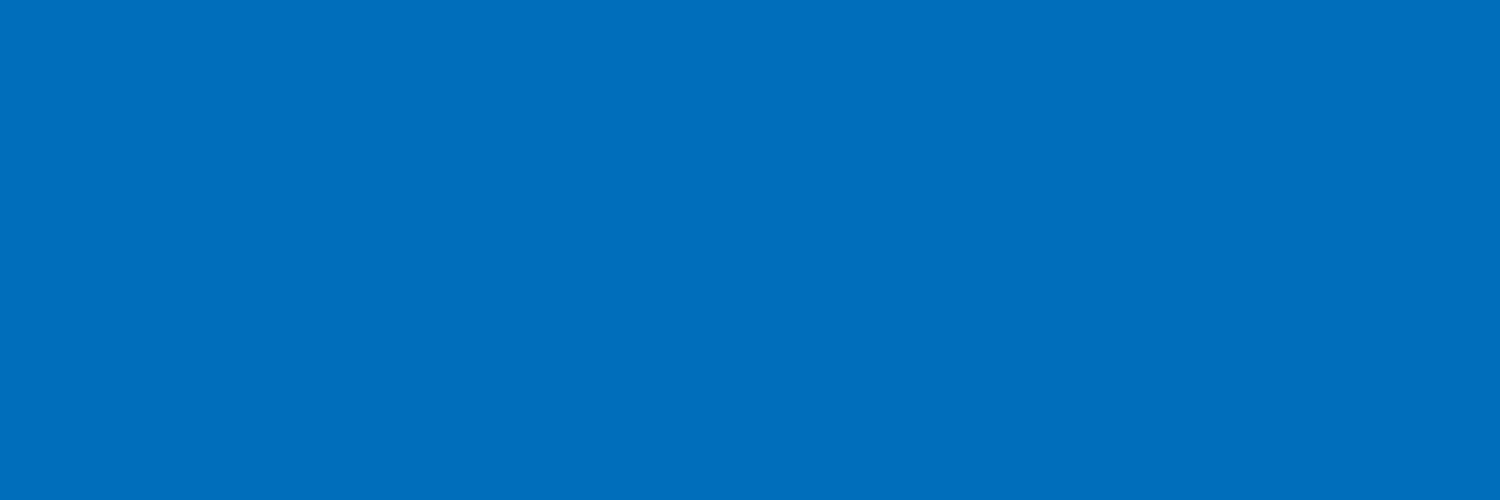

In [213]:
to_pil(cv_bgr)

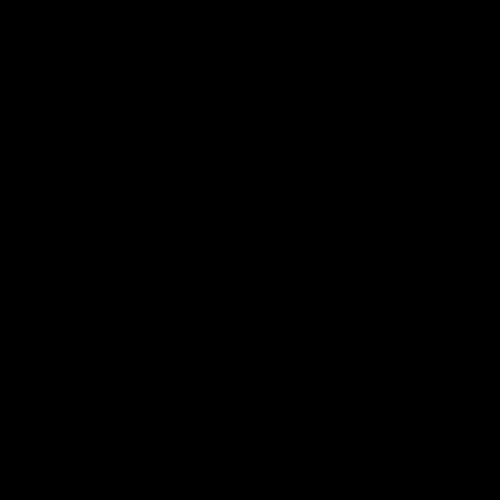

In [127]:
to_pil(cv_bgr)

In [7]:
np.unique(lab_colors)

array(['beige', 'black', 'blue', 'brown', 'cyan', 'gold', 'gray', 'green',
       'khaki', 'maroon', 'orange', 'pink', 'purple', 'red', 'teal',
       'white', 'yellow'], dtype='<U6')

In [181]:
# cv_bgr_black = create_bgr([0,0,0])
cv_bgr_black = create_bgr([255,255,255])
cv_lab_black = cv2.cvtColor(cv_bgr_black, cv2.COLOR_BGR2LAB)
cie_lab_black = lab_cv2cie(cv_lab_black)

In [182]:
cie_lab_black

array([[[100.,   0.,   0.],
        [100.,   0.,   0.],
        [100.,   0.,   0.],
        ...,
        [100.,   0.,   0.],
        [100.,   0.,   0.],
        [100.,   0.,   0.]],

       [[100.,   0.,   0.],
        [100.,   0.,   0.],
        [100.,   0.,   0.],
        ...,
        [100.,   0.,   0.],
        [100.,   0.,   0.],
        [100.,   0.,   0.]],

       [[100.,   0.,   0.],
        [100.,   0.,   0.],
        [100.,   0.,   0.],
        ...,
        [100.,   0.,   0.],
        [100.,   0.,   0.],
        [100.,   0.,   0.]],

       ...,

       [[100.,   0.,   0.],
        [100.,   0.,   0.],
        [100.,   0.,   0.],
        ...,
        [100.,   0.,   0.],
        [100.,   0.,   0.],
        [100.,   0.,   0.]],

       [[100.,   0.,   0.],
        [100.,   0.,   0.],
        [100.,   0.,   0.],
        ...,
        [100.,   0.,   0.],
        [100.,   0.,   0.],
        [100.,   0.,   0.]],

       [[100.,   0.,   0.],
        [100.,   0.,   0.],
        [100.,  

In [173]:
lab_matrix[lab_colors=='white']

array([[ 9.99999845e+01, -4.59389408e-04, -8.56145792e-03],
       [ 1.18237940e+02,  6.59493538e+00, -1.69011435e+01],
       [ 1.18612886e+02, -5.33101226e-04, -9.93519579e-03],
       [ 1.29027946e+02, -1.41764300e+01,  7.35545045e+00],
       [ 1.33022057e+02, -1.03881478e+01,  7.51322431e+00],
       [ 1.30124680e+02, -5.78690854e-04, -1.07848316e-02],
       [ 1.33794127e+02, -5.92942218e+00,  1.96566294e+00],
       [ 1.30603222e+02,  4.52982868e+00, -6.52488742e+00],
       [ 1.31988970e+02,  1.66849828e+00, -4.48603114e+00],
       [ 1.26445020e+02,  2.41503241e+00,  1.51090712e+01],
       [ 1.28517032e+02,  2.20043540e+00,  7.88841934e+00],
       [ 1.30500605e+02,  4.82961955e-01,  1.07904762e+01],
       [ 1.32829509e+02, -8.90623150e+00,  2.89743567e+01],
       [ 1.30980983e+02,  3.27815589e+00,  5.71581644e+00],
       [ 1.32640312e+02,  2.69044080e-01,  7.15140572e+00],
       [ 1.32957655e+02,  2.48363830e+00,  8.70776144e-01],
       [ 1.34495126e+02, -3.49890127e+00

In [80]:
white_lab = lab_matrix[lab_colors == 'white']
black_lab = lab_matrix[lab_colors == 'black']

In [83]:
max_de = delta_e_cie2000(white_lab[0], black_lab)

In [85]:
max_de.max()

99.99998490203575

In [31]:
np.unique(lab_colors)

array(['beige', 'black', 'blue', 'brown', 'cyan', 'gold', 'gray', 'green',
       'khaki', 'maroon', 'orange', 'pink', 'purple', 'red', 'teal',
       'white', 'yellow'], dtype='<U6')

In [30]:
for b, g, r in np.squeeze(cv_bgr):
    print(b,g,r)

0 24 37
9 8 11
170 65 41
4 61 107
219 231 31
0 134 174
184 187 189
37 164 66
0 55 57
23 1 82
0 105 219
144 0 224
141 0 123
21 13 186
133 157 15
58 66 67
1 202 211


In [35]:
mask = lab_colors == 'blue'

In [38]:
from sklearn.cluster import DBSCAN


In [45]:
lab_matrix[mask,:]

array([[  8.30566263,  39.85143396, -54.28106616],
       [  8.47604225,  40.13078748, -54.66156958],
       [  8.64612588,  40.40965569, -55.04141196],
       ...,
       [ 37.39302572,  81.0878837 , -98.673802  ],
       [ 37.50999473,  81.30873314, -99.0397929 ],
       [ 71.97153117,  -4.94462472, -42.78225755]])

In [48]:
lab_matrix[mask,:][::100]

array([[   8.30566263,   39.85143396,  -54.28106616],
       [  24.22342107,   65.95010525,  -89.82969169],
       [   2.85172837,   20.03926306,  -34.84045863],
       ...,
       [  31.42609893,   77.58016955, -105.38558547],
       [  35.28964276,   78.24525784,  -96.00054788],
       [  35.69403816,   78.44510764,  -95.3168025 ]])

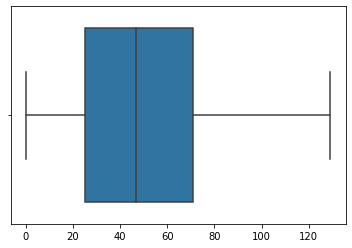

In [77]:
sns.boxplot(dist)

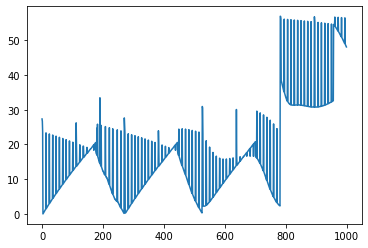

In [67]:
import seaborn as sns 
sns.lineplot(x=range(dist[:1000].shape[0]), y=dist[:1000])